In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
data_dir = "EuroSAT_RGB"  # Replace with the actual path to your dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [4]:
# Load a pre-trained ResNet50 model
#model = models.resnet50(pretrained=True)

#model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(dataset.classes))


# Load a pretrained AlexNet model
model = models.alexnet(pretrained=True)  # Load the pretrained model
num_classes = len(dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Change the output layer


# num_classes = len(dataset.classes)
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/milindbhatia/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [01:23<00:00, 2.93MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

[1,   100] loss: 0.693
[1,   200] loss: 0.339
[1,   300] loss: 0.294
[2,   100] loss: 0.209
[2,   200] loss: 0.207
[2,   300] loss: 0.178
[3,   100] loss: 0.165
[3,   200] loss: 0.170
[3,   300] loss: 0.162
[4,   100] loss: 0.126
[4,   200] loss: 0.156
[4,   300] loss: 0.133
[5,   100] loss: 0.125
[5,   200] loss: 0.115
[5,   300] loss: 0.102
[6,   100] loss: 0.094
[6,   200] loss: 0.096
[6,   300] loss: 0.090
[7,   100] loss: 0.076
[7,   200] loss: 0.073
[7,   300] loss: 0.066
[8,   100] loss: 0.077
[8,   200] loss: 0.079
[8,   300] loss: 0.080
[9,   100] loss: 0.068
[9,   200] loss: 0.060
[9,   300] loss: 0.063
[10,   100] loss: 0.063
[10,   200] loss: 0.051
[10,   300] loss: 0.057
Finished Training


In [6]:
model.eval()

correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print("Accuracy on test set: {:.2f}%".format(accuracy))



Accuracy on test set: 96.57%


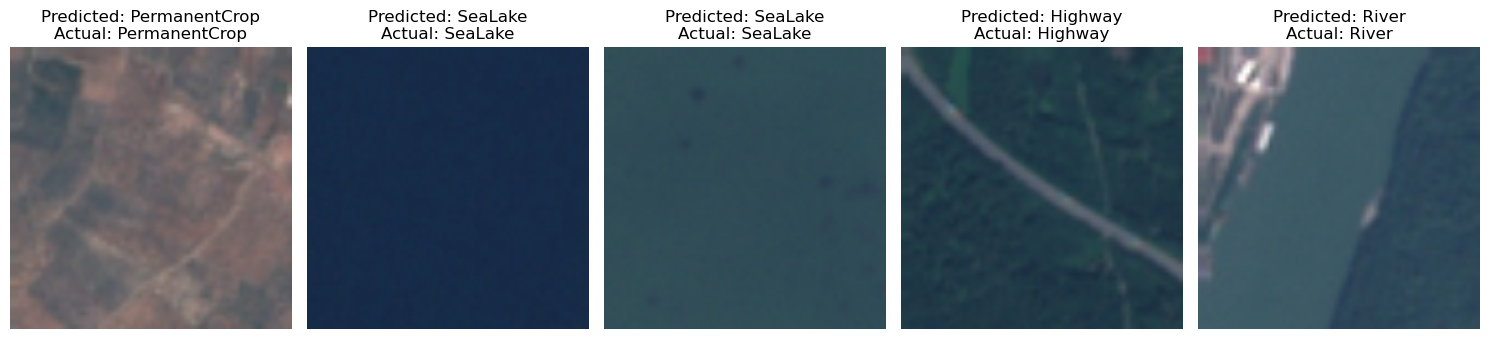

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Visualize some test images along with predicted and actual labels
num_images_to_show = 5
indices = np.random.choice(len(test_dataset), num_images_to_show, replace=False)

# Transformation to convert tensors to PIL images
to_pil = transforms.Compose([transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                            transforms.ToPILImage()])

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    predicted_label = predicted_labels[idx]
    
    # Convert tensor back to PIL image
    pil_image = to_pil(image)
    
    ax = plt.subplot(1, num_images_to_show, i + 1)
    ax.imshow(pil_image)
    ax.set_title(f"Predicted: {test_dataset.dataset.classes[predicted_label]}\nActual: {test_dataset.dataset.classes[label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

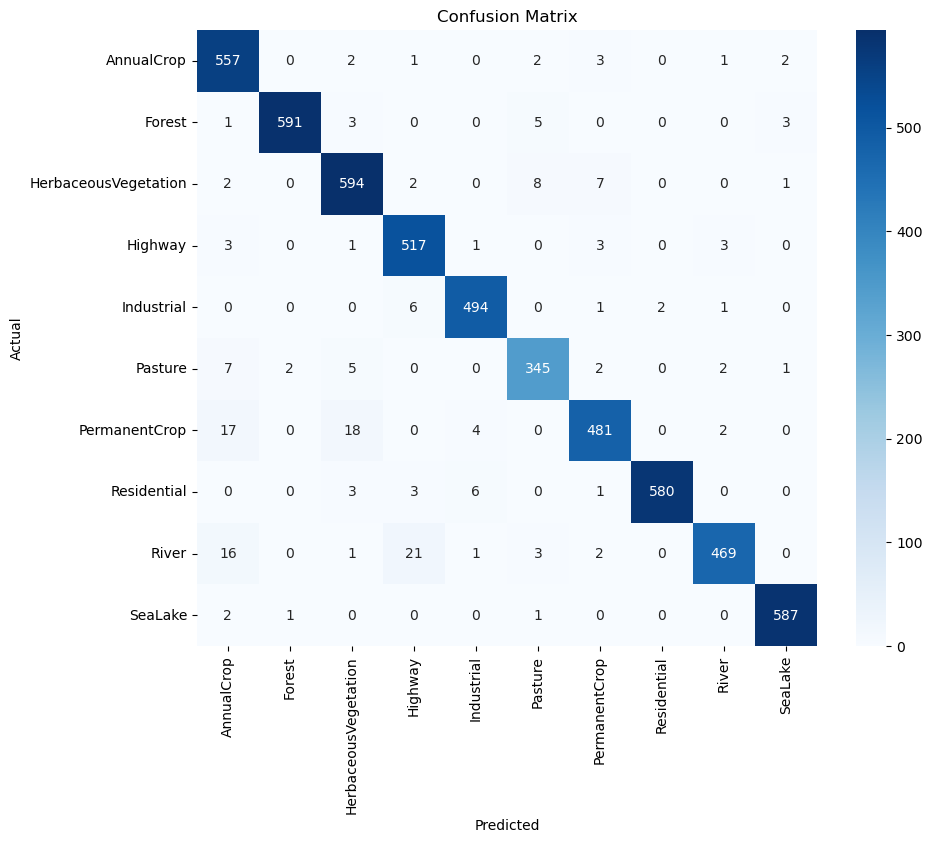

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.dataset.classes, yticklabels=test_dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()